In [1]:
import numpy as np
import seaborn as sns
from graspologic.plot import heatmap
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from sklearn.neighbors import KernelDensity

In [2]:
from graspologic.datasets import load_mice
from grakel import Graph

# Load the full mouse dataset
mice = load_mice()

# Stack all adjacency matrices in a 3D numpy array
graphs = np.array(mice.graphs)
print(graphs.shape)

# initialize labels
labels = {}
for i in np.arange(0, 332):
    labels[i] = i

# Convert adjacency matrices to grakel objects
Gs = []
for graph in graphs:
    Gs.append(Graph(initialization_object = graph, node_labels=labels))
print(len(Gs))

(32, 332, 332)
32


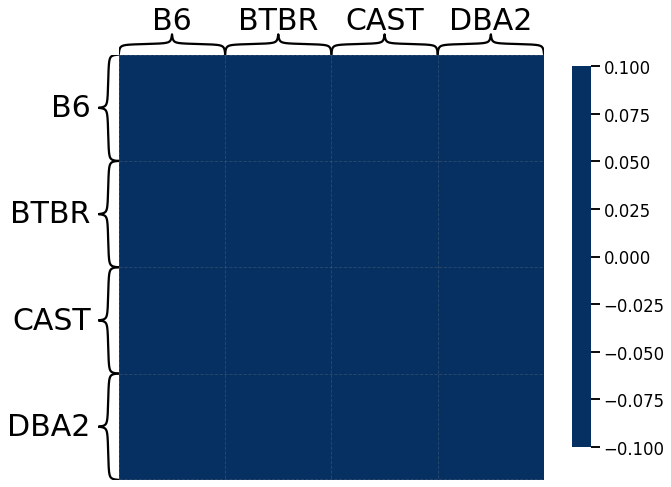

In [4]:
laps = np.zeros(np.shape(graphs))
scaled_kdes = np.zeros((np.shape(graphs)[0], 2000))

for i, graph in enumerate(graphs):
    #lap = csgraph.laplacian(graph, normed=True)

    # find normalized laplacian of each adjacency matrix
    diags = np.sum(graphs[0], axis=1)
    deg_mat = np.diag(diags)
    lap = np.eye(np.shape(graphs)[1]) - np.matmul(np.linalg.inv(deg_mat), graphs[0])
    laps[i] = lap

    # find eigenvalues
    w = np.linalg.eigvals(lap)

    # check eigenvalues are between 0 and 2
    if np.any(w <= 0) or np.any(w > 2):
        print('Eigenvalues must be between 0 and 2.')
    
    # smooth eigenvalue spectrum using Gaussian kernel
    xs = np.linspace(0, 2, 2000)
    kde = np.zeros(np.shape(xs))
    for j, x in enumerate(xs):
        temp = np.exp(-(np.abs(x - w)**2)/ (2 * 0.015**2)) / np.sqrt(2 * np.pi * 0.0015**2)
        temp_sum = np.sum(temp)
        kde[j] = temp_sum
    
    # normalize kde so that area under curve is 1
    scaled_kde = kde / np.trapz(kde, dx=0.001)
    scaled_kdes[i] = scaled_kde

    # check area under scaled_kde is 1
    if np.trapz(scaled_kde, dx=0.001) != 1.0:
        print("KDE is not normalized.")
    
dissim_matrix = np.zeros((len(graphs), len(graphs)))
for i, metric1 in enumerate(scaled_kdes):
    for j, metric2 in enumerate(scaled_kdes):
            diff = cosine(metric1, metric2)
            #diff = np.linalg.norm(metric1 - metric2, ord=1)
            dissim_matrix[i, j] = diff

#scaled_dissim = dissim_matrix / np.max(dissim_matrix)

ax = heatmap(dissim_matrix, context="talk", inner_hier_labels=mice.labels)
ax.figure.set_facecolor('w')


1.0
(2000,)
0.08026985446497661


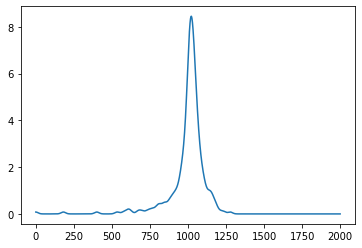

In [7]:
### running one example
diags = np.sum(graphs[0], axis=1)
deg_mat = np.diag(diags)
lap = np.eye(np.shape(graphs)[1]) - np.matmul(np.linalg.inv(deg_mat), graphs[0])
ws = np.linalg.eigvals(lap)

xs = np.linspace(0, 2, 2000)
kde = np.zeros(np.shape(xs))
for i, x in enumerate(xs):
    temp = np.exp(-(np.abs(x - ws)**2)/ (2 * 0.015**2)) / np.sqrt(2 * np.pi * 0.0015**2)
    temp_sum = np.sum(temp)
    kde[i] = temp_sum

scaled_kdes = np.zeros((2, 2000))
scaled_kde = kde / np.trapz(kde, dx=0.001)
scaled_kdes[1] = scaled_kde
print(np.trapz(scaled_kde, dx=0.001))
print(np.shape(scaled_kde))
print(np.max(scaled_kde[0]))

fig = plt.figure(facecolor='w')
plt.plot(scaled_kde)

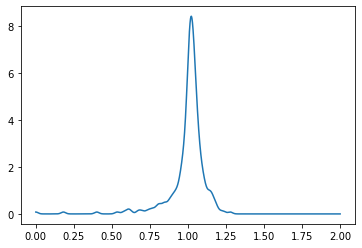

In [8]:
### try gaussian kernel from sklearn
kde1 = KernelDensity(kernel='gaussian', bandwidth=0.015).fit(ws.reshape(-1, 1))
plot_xs = xs[:, np.newaxis]
log_dens = kde1.score_samples(plot_xs)
plt.figure(facecolor='w')
plt.plot(plot_xs[:, 0], np.exp(log_dens))

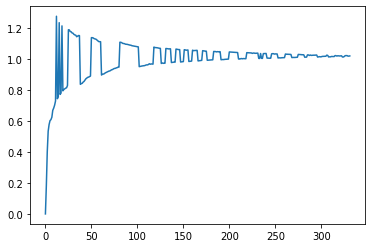

In [53]:
### see what eigenvalue spectrum looks like
plt.figure(facecolor='w')
plt.plot(ws)

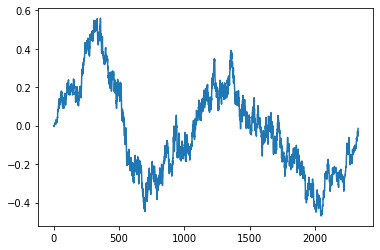

In [10]:
### try convolving with gaussian distribution - different plot?
testx = np.random.normal(0, 0.015, 2000)
kde2 = np.convolve(ws, testx)
plt.figure(facecolor='w')
plt.plot(kde2)